In [20]:
import numpy as np
import os
import time
import random
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [21]:
batch_size = 32
img_height = 188
img_width = 140

data_dir_train = "mini_project_dataset/train"
data_dir_validation = "mini_project_dataset/validation"
data_dir_test = "mini_project_dataset/test"

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 988 files belonging to 2 classes.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 2 classes.


In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 2 classes.


In [25]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000).repeat(3)
    
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x, 0.2), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


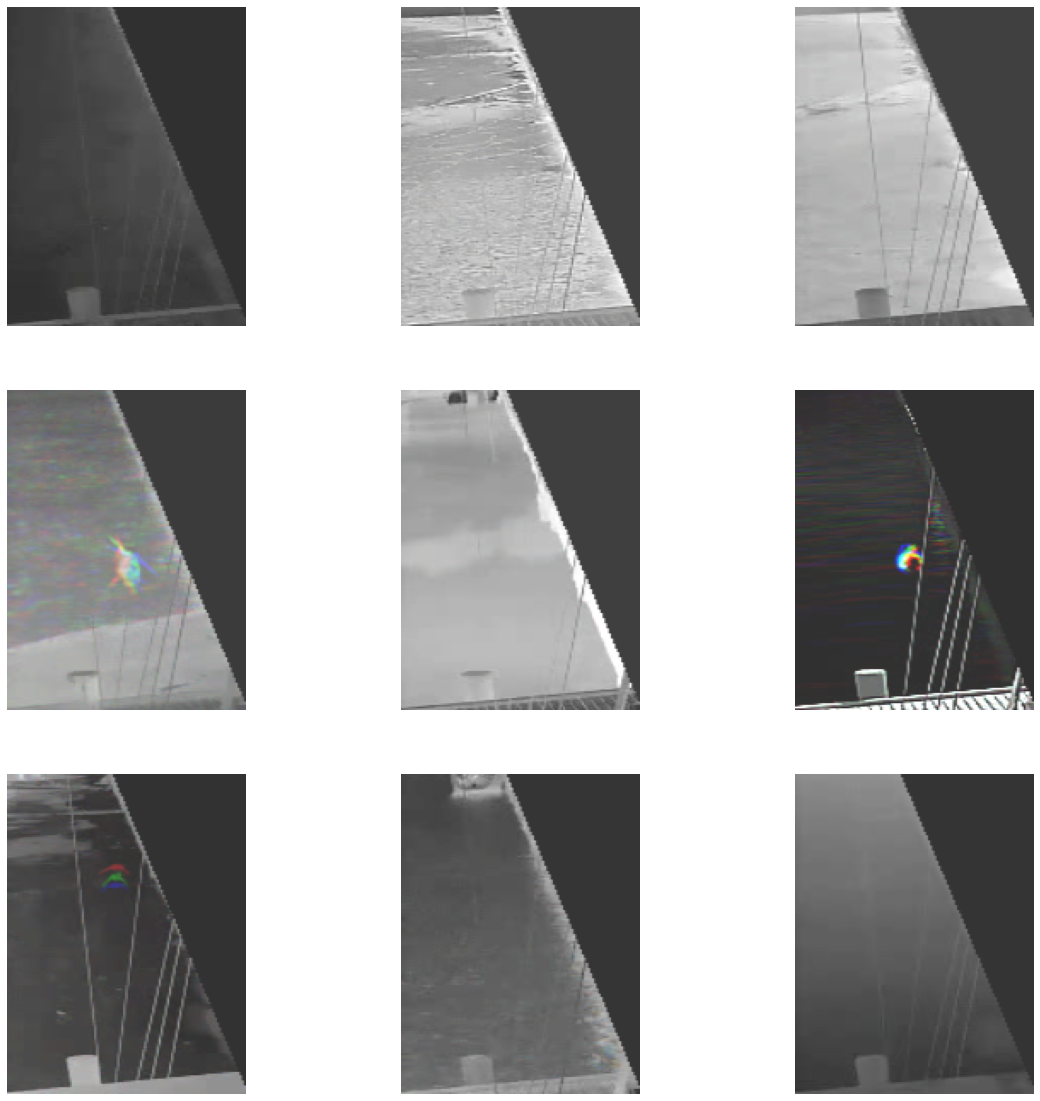

In [26]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

In [27]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(
      learning_rate=0.0001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
      name="Adam"),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [29]:
if not os.path.exists('logs'):
    os.makedirs('logs')

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    run_id = "learning_rate=0.0001"
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [ ]:
run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  callbacks=[tensorboard_cb]
)

Epoch 1/20
93/93 [==============================] - 42s 408ms/step - loss: 0.6561 - accuracy: 0.6056 - val_loss: 0.5877 - val_accuracy: 0.7167
Epoch 2/20
93/93 [==============================] - 39s 405ms/step - loss: 0.5336 - accuracy: 0.7743 - val_loss: 0.5083 - val_accuracy: 0.7867
Epoch 3/20
93/93 [==============================] - 39s 391ms/step - loss: 0.4484 - accuracy: 0.8124 - val_loss: 0.5006 - val_accuracy: 0.8000
Epoch 4/20
93/93 [==============================] - 39s 401ms/step - loss: 0.3874 - accuracy: 0.8495 - val_loss: 0.4129 - val_accuracy: 0.8367
Epoch 5/20
93/93 [==============================] - 41s 418ms/step - loss: 0.3353 - accuracy: 0.8681 - val_loss: 0.3568 - val_accuracy: 0.8700
Epoch 6/20
93/93 [==============================] - 37s 371ms/step - loss: 0.2537 - accuracy: 0.9082 - val_loss: 0.3389 - val_accuracy: 0.8667
Epoch 7/20
93/93 [==============================] - 36s 359ms/step - loss: 0.2153 - accuracy: 0.9194 - val_loss: 0.3310 - val_accuracy: 0.8833

In [11]:
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
#%tensorboard --logdir=./logs --port=6006 